In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

paths = []
labels = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.wav'):  # Only process audio files
            full_path = os.path.join(dirname, filename)
            parts = filename.split('-')
            if len(parts) == 7:
                emotion_code = parts[2]
                emotion = emotion_map.get(emotion_code)
                if emotion:
                    paths.append(full_path)
                    labels.append(emotion.lower())
                    # print(full_path)
                    # print(emotion)

print(f"Loaded {len(paths)} audio files with emotion labels.")


Loaded 2452 audio files with emotion labels.


In [3]:
paths[:5]

['/kaggle/input/ravdess-dataset/Audio_Song_Actors_01-24/Actor_02/03-02-05-02-01-01-02.wav',
 '/kaggle/input/ravdess-dataset/Audio_Song_Actors_01-24/Actor_02/03-02-06-01-02-02-02.wav',
 '/kaggle/input/ravdess-dataset/Audio_Song_Actors_01-24/Actor_02/03-02-03-02-01-02-02.wav',
 '/kaggle/input/ravdess-dataset/Audio_Song_Actors_01-24/Actor_02/03-02-03-01-02-02-02.wav',
 '/kaggle/input/ravdess-dataset/Audio_Song_Actors_01-24/Actor_02/03-02-04-02-01-01-02.wav']

In [4]:
labels[:5]

['angry', 'fearful', 'happy', 'happy', 'sad']

In [5]:
df=pd.DataFrame()
df['audio']=paths
df['label']=labels
df.head()

,audio,label
0,/kaggle/input/ravdess-dataset/Audio_Song_Actor...,angry
1,/kaggle/input/ravdess-dataset/Audio_Song_Actor...,fearful
2,/kaggle/input/ravdess-dataset/Audio_Song_Actor...,happy
3,/kaggle/input/ravdess-dataset/Audio_Song_Actor...,happy
4,/kaggle/input/ravdess-dataset/Audio_Song_Actor...,sad


In [6]:
df['label'].value_counts()

label
angry        376
fearful      376
happy        376
sad          376
calm         376
surprised    192
disgust      192
neutral      188
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

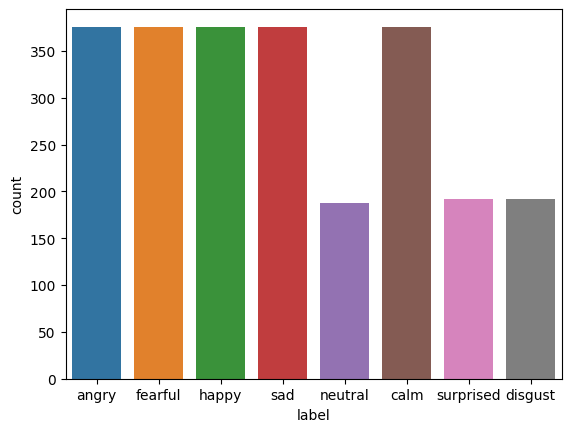

In [7]:
sns.countplot(x='label', data=df)

In [8]:
def extract_mfcc(filename):
    y,sr=librosa.load(filename,duration=3,offset=0.5)
    mfcc=np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40).T,axis=0)
    return mfcc

In [9]:
extract_mfcc(df['audio'][0])

array([-314.09363  ,   36.614197 ,  -52.30196  ,    9.302675 ,
        -26.95602  ,  -22.54238  ,    9.237684 ,  -23.687853 ,
        -12.041176 ,   -5.062075 ,  -12.012909 ,   -2.1899338,
        -13.022907 ,   -1.1667689,  -14.128816 ,   -7.9419584,
         -7.690515 ,    1.782416 ,    4.540728 ,   16.358473 ,
         19.703182 ,   13.069858 ,    7.0601516,    0.5982224,
         -7.390571 ,   -1.0411179,    3.5549912,    3.3103747,
         -1.1166241,   -9.758704 ,   -4.1091046,    6.51336  ,
          3.4340696,   -2.9677308,   -4.2778187,    2.1499147,
         -1.1763197,   -2.6263583,    0.5697479,    9.194491 ],
      dtype=float32)

In [10]:
X_mfcc=df['audio'].apply(lambda x: extract_mfcc(x))

In [11]:
X_mfcc

0       [-314.09363, 36.614197, -52.30196, 9.302675, -...
1       [-458.25647, 26.995949, -39.305195, 8.289539, ...
2       [-413.82574, 34.523315, -59.518276, 9.515924, ...
3       [-462.42102, 37.603046, -49.82877, 5.66308, -2...
4       [-501.1082, 34.84351, -31.733484, 2.3917415, -...
                              ...                        
2447    [-602.25903, 62.618538, -8.6473675, 8.951977, ...
2448    [-450.15335, 64.146095, -2.0737228, 17.278877,...
2449    [-561.08777, 83.76006, -7.141875, 15.231575, 1...
2450    [-496.09958, 55.643986, 16.767818, 21.994936, ...
2451    [-306.2437, 43.048687, -17.571423, 14.701662, ...
Name: audio, Length: 2452, dtype: object

In [12]:
X=[x for x in X_mfcc]
X=np.array(X)
X.shape

(2452, 40)

In [13]:
X=np.expand_dims(X,-1)
X.shape

(2452, 40, 1)

In [14]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
y=enc.fit_transform(df[['label']])

In [15]:
print(y.shape)
y=y.toarray()

(2452, 8)


In [16]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
model=Sequential([
    LSTM(123,return_sequences=False,input_shape=(40,1)),
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(32,activation='relu'),
    Dropout(0.2),
    Dense(8,activation='softmax')

])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

2025-06-13 07:14:43.170530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749798883.420856      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749798883.490381      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-13 07:14:58.282600: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 123)                 │          61,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           7,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,780 (280.39 KB)

 Trainable params: 71,780 (280.39 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history=model.fit(X,y,validation_split=0.2,epochs=100,batch_size=512,shuffle=True)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 376ms/step - accuracy: 0.0970 - loss: 2.1264 - val_accuracy: 0.1976 - val_loss: 2.0660
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.1741 - loss: 2.0594 - val_accuracy: 0.1507 - val_loss: 2.0552
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.1777 - loss: 2.0443 - val_accuracy: 0.1833 - val_loss: 2.0444
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.1819 - loss: 2.0228 - val_accuracy: 0.1874 - val_loss: 2.0318
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.1942 - loss: 2.0028 - val_accuracy: 0.1996 - val_loss: 2.0185
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.1949 - loss: 1.9786 - val_accuracy: 0.2057 - val_loss: 2.0014
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.2181 - loss: 1.9410 - val_accuracy: 0.2016 - val_loss: 1.9828
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.2307 - loss: 1.9238 - val_accuracy: 0.1955 - v

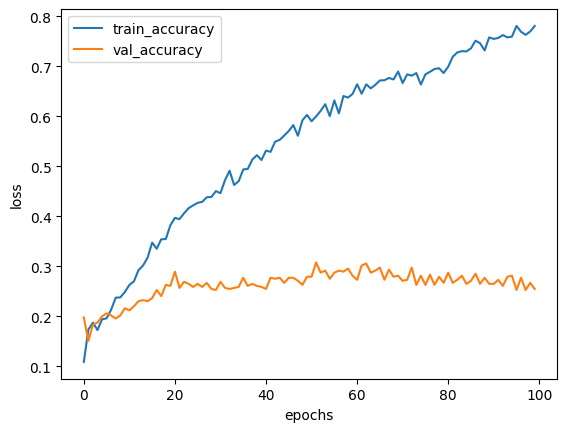

In [18]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(100)
plt.plot(epochs,acc,label='train_accuracy')
plt.plot(epochs,val_acc,label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

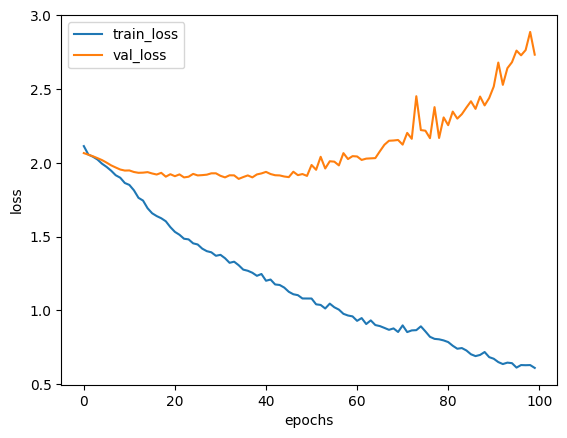

In [19]:
loss=history.history['loss']
val_loss=history.history['val_loss']
plt.plot(epochs,loss,label='train_loss')
plt.plot(epochs,val_loss,label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [20]:
paths=[]
labels=[]

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname,filename))
        print(filename)
        label=filename.split('_')[-1]
        print(label)
        label=label.split('.')[0]
        print(label)
        labels.append(label.lower())
print('Dataset is loaded')

02-01-08-02-02-01-15.mp4
02-01-08-02-02-01-15.mp4
02-01-08-02-02-01-15
02-01-05-01-01-02-15.mp4
02-01-05-01-01-02-15.mp4
02-01-05-01-01-02-15
02-01-03-02-02-01-15.mp4
02-01-03-02-02-01-15.mp4
02-01-03-02-02-01-15
02-01-08-01-01-01-15.mp4
02-01-08-01-01-01-15.mp4
02-01-08-01-01-01-15
02-01-07-01-01-02-15.mp4
02-01-07-01-01-02-15.mp4
02-01-07-01-01-02-15
02-01-03-01-01-01-15.mp4
02-01-03-01-01-01-15.mp4
02-01-03-01-01-01-15
02-01-02-01-02-02-15.mp4
02-01-02-01-02-02-15.mp4
02-01-02-01-02-02-15
01-01-01-01-02-01-15.mp4
01-01-01-01-02-01-15.mp4
01-01-01-01-02-01-15
01-01-02-01-01-02-15.mp4
01-01-02-01-01-02-15.mp4
01-01-02-01-01-02-15
01-01-03-02-01-02-15.mp4
01-01-03-02-01-02-15.mp4
01-01-03-02-01-02-15
02-01-01-01-02-01-15.mp4
02-01-01-01-02-01-15.mp4
02-01-01-01-02-01-15
01-01-03-01-01-01-15.mp4
01-01-03-01-01-01-15.mp4
01-01-03-01-01-01-15
02-01-02-02-01-01-15.mp4
02-01-02-02-01-01-15.mp4
02-01-02-02-01-01-15
01-01-07-02-01-01-15.mp4
01-01-07-02-01-01-15.mp4
01-01-07-02-01-01-15
02-01-